# Water Treatment Plant: Inliers and Outliers

## Introduction

This notebook will go through some different ways of quantitatively detecting outliers using various unsupervised learning techniques.

In [2]:
# numerics
import numpy as np
import pandas as pd
from scipy import stats

# learn you some machines
from sklearn import linear_model

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

# essentials
from pprint import pprint
import os, io, re
from datetime import datetime

In [3]:
# Read water treatment plant data into a dataframe
df = pd.read_csv('data/water_treatment/water-treatment.data',
                    na_values='?',
                    header=None)

# Load information about column codes and their descriptions
info = pd.read_csv('data/water_treatment/water-treatment.names',
                    engine='python',
                    skiprows=64, nrows=38, 
                    names = ['Code','Description'],
                    header=None, 
                    index_col=0,
                    na_values='?',
                    delimiter=r' {2,}')

inputs      = info[  info['Description'].apply(lambda x : '(input' in x)  ]

plant_inputs      = info[  info['Description'].apply(lambda x : '(input' in x and 'plant' in x)  ]
tank1_inputs      = info[  info['Description'].apply(lambda x : '(input' in x and 'primary settler' in x)  ]
tank2_inputs      = info[  info['Description'].apply(lambda x : '(input' in x and 'secondary settler' in x)  ]
outputs     = info[  info['Description'].apply(lambda x : '(output' in x)   ]

perf_inputs = info[  info['Description'].apply(lambda x : '(performance input' in x)  ]
glob_inputs = info[  info['Description'].apply(lambda x : '(global performance input' in x)  ]

# Column labes are the codes, plus one more column for "Date"
column_labels = np.concatenate([np.array(['Date']), info['Code'].values])
df.columns = column_labels

# Parse the Date column from D-(day)/(month)/(yr) to datetime
df['Date'] = df['Date'].apply(lambda x : datetime.strptime(x,'D-%d/%m/%y'))

# Use the date as the index
df.set_index('Date')

print("")

# Outlier Detection via Linear Models

The first outlier detection technique relies on the use of linear models to fit empirical data. We'll use our knowledge of the physical system to guide an appropriate choice of variables to model.

Think of the entire waste water treatment plant as a set of linear processes. Each process can be thought of as a block operation that has inputs and outputs. We are modifying the inputs in some way in the physical process, whether increasing or decreasing, and the output is passed on to the next stage of the process. If we look at the relationship between inputs and outputs, we should see some functional relationship that represents what the plant is trying to accomplish. We should also see outliers, corresponding to malfunctions or irregular states for the water treatment facility. These are the states that we are trying to predict.

The following plots show the ratio of a given variable at the inputs to the plant to primary settling tank, primary settling tank to secondary settling tank, and secondary settling tank to outlet. The variable shown is suspended solids. We would expect that this quantity would always be reduced, since that is one of the principal goals of a wastewater treatment plant. 

The following plots show the inputs to a given stage on the x axis, and the output to the next stage on the y axis. Each plot has a black line representing $y=x$. For points falling on this line, this stage has no affect on the variable value. For points above this line, the variable value increases as a result of this stage. For points falling below this line, this stage reduces the variable value.

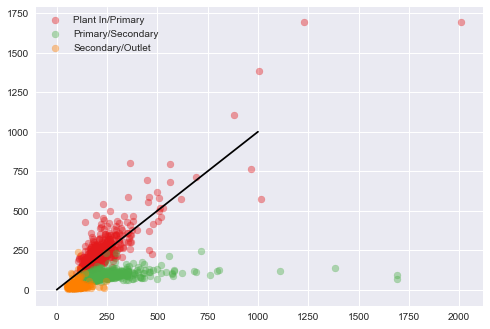

In [31]:
# color by label suffix (plant input, primary input, secondary input)
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]

colorz = get_cmap(4)

zippy = np.linspace(0,1000,5)
plt.plot(zippy,zippy,'k-')
plt.scatter(df['SS-E'].values, df['SS-P'].values, alpha=0.4, color=colorz[0], label='Plant In/Primary')
plt.scatter(df['SS-P'].values, df['SS-D'].values, alpha=0.4, color=colorz[1], label='Primary/Secondary')
plt.scatter(df['SS-D'].values, df['SS-S'].values, alpha=0.4, color=colorz[2], label='Secondary/Outlet')
plt.legend()
plt.show()

The red points, the ratios of plant inputs to primary settling tank inputs, seem to follow the $y=x$ line. Because the is no stage between the plant input and the primary settling tank input, this is to be expected. However, there is a large variance in the data that indicate something affecting the inlet stream between the input to the plant and the input to the primary settling tank.

The following function uses scikit-learn's `linear_model` module to fit a linear regression model to the data, and plots each separately.

In [32]:
def plot_block_input_output_regression(lab1, lab2, mycolor):
    # use scikit-learn linear_model
    # build linear model of input vs. output
    lmreg = linear_model.LinearRegression( fit_intercept = False )
    dat = df[[lab1, lab2]].dropna()
    lmreg.fit( dat[lab1].values.reshape(-1,1), dat[lab2].values.reshape(-1,1) )
    
    xx = np.linspace(0,1300,100)
    yy = lmreg.predict(xx.reshape(-1,1))

    fig = plt.figure(figsize=(6,5))
    
    ax1 = fig.add_subplot(111)
    
    zippy = np.linspace(0,1000,5)
    ax1.plot(zippy,zippy,'k-')
    ax1.scatter(df[lab1].values, df[lab2].values, alpha=0.4, color=mycolor, label=lab1+" v "+lab2)
    ax1.plot(xx, yy, '-', color=mycolor, label='Linear Regression')
    
    ax1.set_xlabel(lab1)
    ax1.set_ylabel(lab2)
    ax1.legend(loc='upper left')


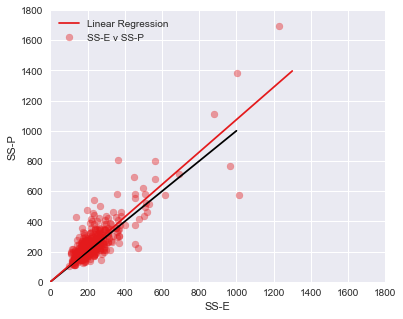

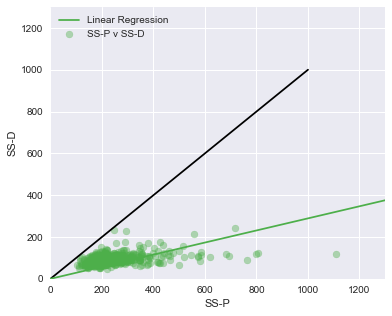

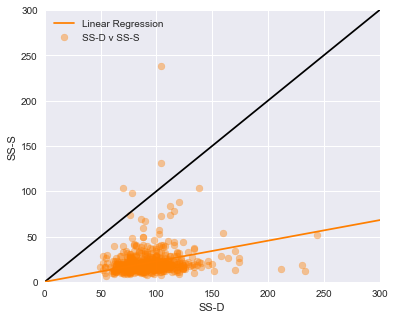

In [33]:
plot_block_input_output_regression('SS-E','SS-P',colorz[0])
gca().set_xlim([0,1800])
gca().set_ylim([0,1800])

plot_block_input_output_regression('SS-P','SS-D',colorz[1])
gca().set_xlim([0,1300])
gca().set_ylim([0,1300])

plot_block_input_output_regression('SS-D','SS-S',colorz[2])
gca().set_xlim([0,300])
gca().set_ylim([0,300])

plt.show()

The linear model fit to each stage suggests that the secondary settling tank (above, brown) achieves the greatest reductions in suspended solids. However, there were more anomalies for the secondary tank than for the primary tank - including four observations where the amount of suspended solids was increased by the secondary settling tank.

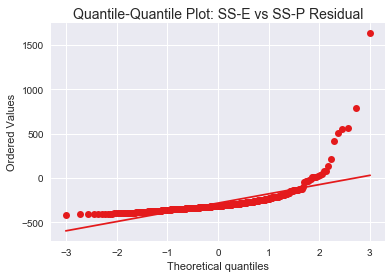

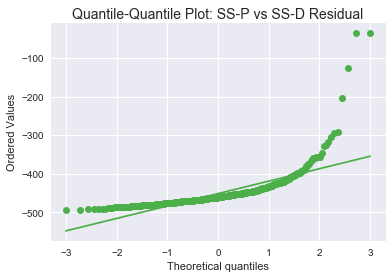

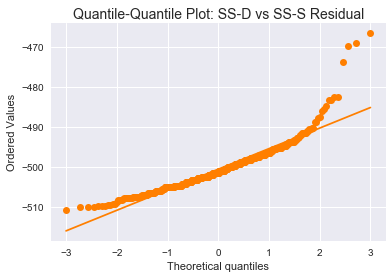

In [34]:
def plot_input_output_qq(lab1,lab2, mycolor):

    # use scikit-learn linear_model
    # build linear model of input vs. output
    ###lab1 = 'SS-E'
    ###lab2 = 'SS-P'
    lmreg = linear_model.LinearRegression( fit_intercept = False )
    dat = df[[lab1, lab2]].dropna()
    lmreg.fit( dat[lab1].values.reshape(-1,1), dat[lab2].values.reshape(-1,1) )

    xx = dat[[lab1,lab2]].dropna()[lab1].values.reshape(-1,1)
    yyhat = lmreg.predict( xx )
    yy = df[[lab1,lab2]].dropna()[lab1].shape

    resid = yyhat - yy
    resid = resid.reshape(len(resid),)

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)

    stats.probplot(resid, dist='norm', plot=ax)
    
    ax.get_lines()[0].set_color(mycolor)
    ax.get_lines()[1].set_color(mycolor)
    
    plt.title("Quantile-Quantile Plot: "+lab1+" vs "+lab2+" Residual",size=14)
    
    plt.show()
    
plot_input_output_qq('SS-E','SS-P',colorz[0])
plot_input_output_qq('SS-P','SS-D',colorz[1])
plot_input_output_qq('SS-D','SS-S',colorz[2])

Fitting a linear regression for each unit operation in the process provides an easy way of identifying a group of outlier points. Let's see if we can't pick out the outliers, and highlight them in a time series, to see how closely this matches an eyeball estimate.

Here's how we'll do that:
* Create a new data frame from the original data, and add a new column that's the computed residual.
* Plot two time series: one where residual is less than X, and colored green; the other where the the residual is greater than X, and colored red.


In [35]:
def get_lm_resid(lab1, lab2, df):
    # use scikit-learn linear_model
    # build linear model of input vs. output
    df_resid = df[['Date',lab1,lab2]].dropna()

    xx = df_resid[lab1].values.reshape(-1,1)
    yy = df_resid[lab2].values.reshape(-1,1)

    lmreg = linear_model.LinearRegression( fit_intercept = False )
    lmreg.fit(xx,yy)
    yyhat = lmreg.predict(xx)

    resid = yy - yyhat
    resid = resid.reshape(len(resid),)
    df_resid['Residual'] = resid
    
    return df_resid

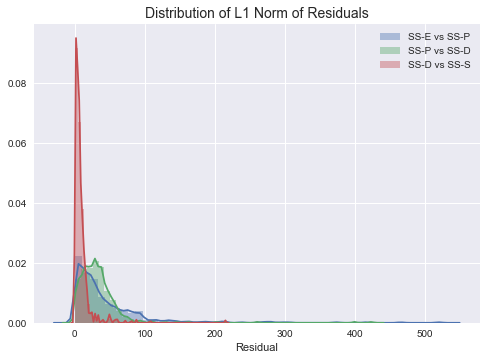

In [36]:
# use scikit-learn linear_model
# build linear model of input vs. output
lab1 = 'SS-E'
lab2 = 'SS-P'
df_residEP = get_lm_resid(lab1, lab2, df)
sns.distplot(df_residEP['Residual'].abs(),
             label=lab1+' vs '+lab2,
             kde_kws={'kernel':'tri'})


lab1 = 'SS-P'
lab2 = 'SS-D'
df_residPD = get_lm_resid(lab1, lab2, df)
sns.distplot(df_residPD['Residual'].abs(),
             label=lab1+' vs '+lab2,
             kde_kws={'kernel':'tri'})


lab1 = 'SS-D'
lab2 = 'SS-S'
df_residDS = get_lm_resid(lab1, lab2, df)
sns.distplot(df_residDS['Residual'].abs(),
             label=lab1+' vs '+lab2,
             kde_kws={'kernel':'tri'})


plt.legend()
plt.title('Distribution of L1 Norm of Residuals', size=14)
plt.show()

### Linear Regression Outliers: Inlet to Primary

This is expected to hover around the $y=x$ line. No unusual outliers expected between plant inlet anad inlet to primary stage.

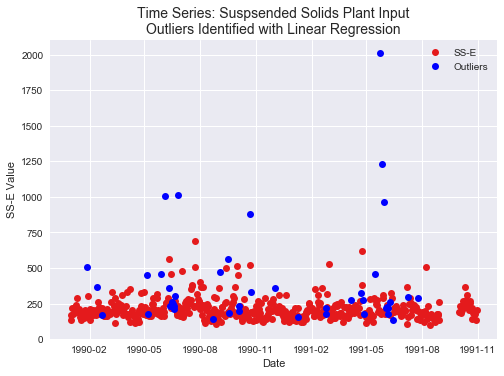

In [37]:
normal_x = df_residEP['Date'][df_resid['Residual'].abs()<100]
normal_y = df_residEP['SS-E'][df_resid['Residual'].abs()<100]

irregular_x = df_residEP['Date'][df_resid['Residual'].abs()>100]
irregular_y = df_residEP['SS-E'][df_resid['Residual'].abs()>100]

plt.plot(normal_x,normal_y,'o',color=colorz[0])
plt.plot(irregular_x,irregular_y,'bo',label="Outliers")

plt.title("Time Series: Suspsended Solids Plant Input\nOutliers Identified with Linear Regression",size=14)
plt.xlabel('Date')
plt.ylabel('SS-E Value')
plt.legend()

plt.show()

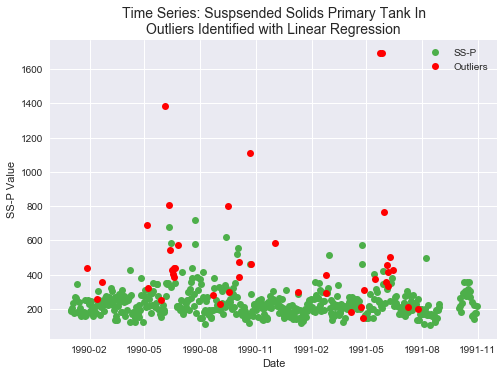

In [38]:
normal_x = df_residEP['Date'][df_resid['Residual'].abs()<100]
normal_y = df_residEP['SS-P'][df_resid['Residual'].abs()<100]

irregular_x = df_residEP['Date'][df_resid['Residual'].abs()>100]
irregular_y = df_residEP['SS-P'][df_resid['Residual'].abs()>100]

plt.plot(normal_x,normal_y,'o',color=colorz[1])
plt.plot(irregular_x,irregular_y,'ro',label="Outliers")

plt.title("Time Series: Suspsended Solids Primary Tank In\nOutliers Identified with Linear Regression",size=14)
plt.xlabel('Date')
plt.ylabel('SS-P Value')
plt.legend()

plt.show()

### Linear Regression Outliers Function

Turn the linear regression model building process and time series plotting process and highlighting of linear regression outliers part of a single function call:

In [39]:
def make_marked_outlier_timeseries(df_resid, lab1, lab2, normal_cutoff, mycolor1, myoutliercolor1, mycolor2, myoutliercolor2):
    # use scikit-learn linear_model
    # build linear model of input vs. output
    df_resid = df[['Date',lab1,lab2]].dropna()

    xx = df_resid[lab1].values.reshape(-1,1)
    yy = df_resid[lab2].values.reshape(-1,1)
    
    lmreg.fit(xx,yy)
    yyhat = lmreg.predict(xx)

    resid = yy - yyhat
    resid = resid.reshape(len(resid),)
    df_resid['Residual'] = resid
    
    
    
    fig = plt.figure(figsize=(10,8))
    ax1, ax2 = [fig.add_subplot(211+k) for k in range(2)]
    
    
    
    normal_x = df_resid['Date'][df_resid['Residual'].abs()<normal_cutoff]
    normal_y = df_resid[lab1][df_resid['Residual'].abs()<normal_cutoff]

    irregular_x = df_resid['Date'][df_resid['Residual'].abs()>normal_cutoff]
    irregular_y = df_resid[lab1][df_resid['Residual'].abs()>normal_cutoff]

    ax1.plot(normal_x,normal_y,'o',color=mycolor1)
    ax1.plot(irregular_x,irregular_y,'o',color=myoutliercolor1,label="Outliers")

    ax1.set_title("Time Series: "+lab1+"\nOutliers Identified with Linear Regression",size=14)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(lab1+" Value")
    ax1.legend()
    
    
    # ------
    
    
    normal_x = df_resid['Date'][df_resid['Residual'].abs()<normal_cutoff]
    normal_y = df_resid[lab2][df_resid['Residual'].abs()<normal_cutoff]

    irregular_x = df_resid['Date'][df_resid['Residual'].abs()>normal_cutoff]
    irregular_y = df_resid[lab2][df_resid['Residual'].abs()>normal_cutoff]

    ax2.plot(normal_x,normal_y,'o',color=mycolor2)
    ax2.plot(irregular_x,irregular_y,'o',color=myoutliercolor2,label="Outliers")

    ax2.set_title("Time Series: "+lab2+"\nOutliers Identified with Linear Regression",size=14)
    ax2.set_xlabel("Date")
    ax2.set_ylabel(lab2+" Value")
    ax2.legend()

    
    fig.subplots_adjust(hspace = 0.5)
    
    plt.show()

### Linear Regression Outlier

Let's look at all three linear regression outliers. Here is the plant inlet to the primary inlet again, highlighting the linear model outliers:

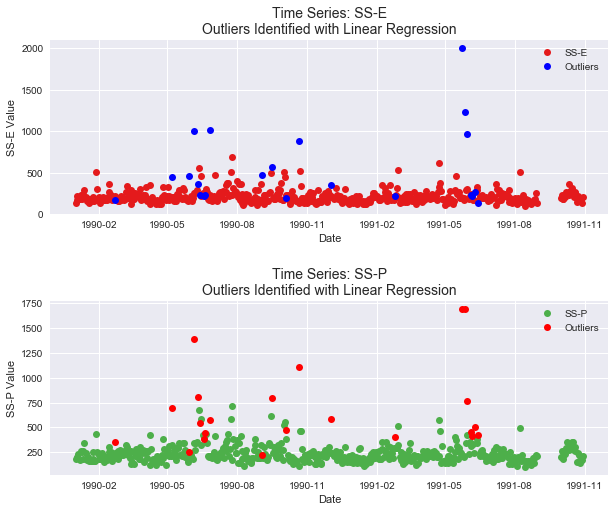

In [40]:
make_marked_outlier_timeseries(df_residEP,'SS-E','SS-P',150,colorz[0],'b',colorz[1],'r')

Next, here is the primary settling tank to the secondary settling tank inputs, with the outliers based on large residuals:

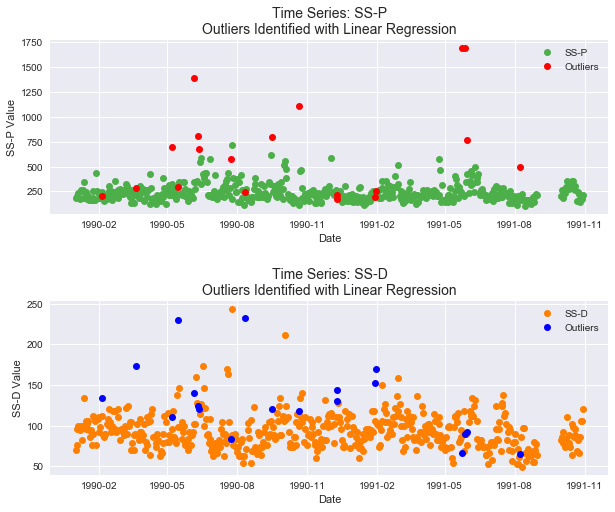

In [42]:
make_marked_outlier_timeseries(df_residPD,'SS-P','SS-D',75,colorz[1],'r',colorz[2],'b')

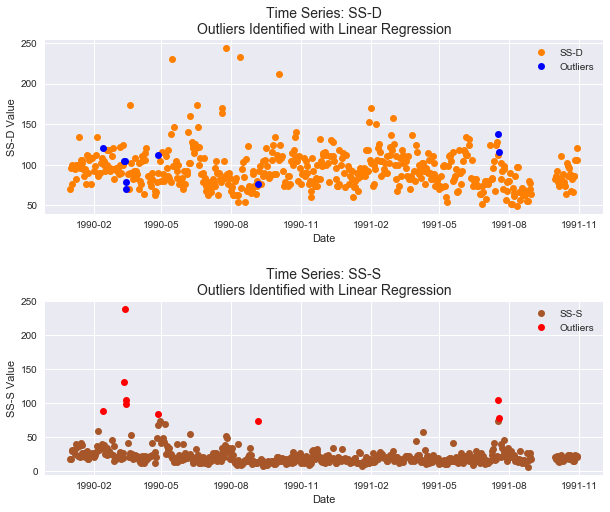

In [44]:
make_marked_outlier_timeseries(df_residDS,'SS-D','SS-S',50,colorz[2],'b',colorz[3],'r')

Note that the outliers above are not selected based on how far the quantity shown deviates from the mean; these are the outliers selected because the ratio of input to output suspended solids is higher than the mean. 

## Robust Outlier Detection: Using the Hat Matrix

While least squares (LS) can be used to detect outliers as demonstrated in the procedure above, this is subject to problems - specifically, least squares is designed to minimize residuals, so by nature the process will result in small residuals. One outlier can throw off the fit of the model with all of the data points (as seen by the crooked lines above).

An alternative approach is leave-one-out or leave-multiple-out diagnostics. This can be done using the hat matrix, which transforms the system responses $\mathbf{y}$ into the model responses $\hat{\mathbf{y}}$:

$$
\hat{\mathbf{y}} = \mathbf{H} \mathbf{y}
$$

To get the hat matrix, let's set down some notation. We are modeling a system response vector $\mathbf{y}$, which has $i = 1 \dots n$ observed instances on 1 response and $p$ explanatory variables. The values of the explanatory variables are contained in an $n \times p$ matrix called $\mathbf{X}$, and the relationship between the two is:

$$
\mathbf{y} = \mathbf{X} \boldsymbol{\theta} + \mathbf{e}
$$

Theta is the vector of unknown parameters and e is the error vector.

Using this notation, the hat matrix can be computed using the following equation:

$$
\mathbf{H} = \mathbf{X} ( \mathbf{X}^{T} \mathbf{X} )^{-1} \mathbf{X}^{T}
$$

This matrix has a couple of useful properties and uses. First, it is invariant to linear transformations, so if we transform our original input data with a linear transformation,

$$
\tilde{\mathbf{X}} = \mathbf{A X}
$$

then 

$$
\tilde{\mathbf{H}} = \mathbf{H}
$$

Furthermore, $h_{ij}$ of $\mathbf{H}$ has an interpretation as the effect exerted by the $j^{th}$ observation on $\hat{y}_i$.

The diagonal elements are of interest, since

$$
h_{ii} = \dfrac{ \partial \hat{y}_i }{\partial y_i}
$$

This is the effect of the $i^{th}$ observation on its own prediction.

The cutoff for influential points is,

$$
h_{ii} > \dfrac{2p}{n}
$$

or 

$$
h_{ii} > \dfrac{3p}{n}
$$

### Getting Input Vector

We can use the list of input and output codes to get the appropriate columns to construct the matrix $\mathbf{X}$. However, we run into a problem: NaNs.

In [45]:
all_labels = ['Date'] + inputs['Code'].tolist() + outputs['Code'].tolist()
nodate_labels = inputs['Code'].tolist() + outputs['Code'].tolist()
df_io = df[all_labels]

print df_io.shape
print df_io.dropna().shape
print 1.0*df_io.dropna().shape[0]/df_io.shape[0]

(527, 30)
(395, 30)
0.749525616698


If we just drop the rows with missing data, we throw away 25% of our data. Yikes.

An alternative approach is to use k-nearest neighbors clustering to impute values (see [this paper](http://conteudo.icmc.usp.br/pessoas/gbatista/files/his2002.pdf) for better defintion of terms).

Here is a count of how many NaNs in each column:

In [46]:
df_io.isnull().sum()

Date       0
Q-E       18
ZN-E       3
PH-E       0
DBO-E     23
DQO-E      6
SS-E       1
SSV-E     11
SED-E     25
COND-E     0
PH-P       0
DBO-P     40
SS-P       0
SSV-P     11
SED-P     24
COND-P     0
PH-D       0
DBO-D     28
DQO-D      9
SS-D       2
SSV-D     13
SED-D     25
COND-D     0
PH-S       1
DBO-S     23
DQO-S     18
SS-S       5
SSV-S     17
SED-S     28
COND-S     1
dtype: int64

Scikit learn has an Imputer object to allow us to impute data. Here's how we use it.

In [48]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values=np.nan,strategy='mean')
df_scrub = imp.fit_transform(df_io[nodate_labels])
print df_scrub

[[  4.41010000e+04   1.50000000e+00   7.80000000e+00 ...,   8.10000000e+01
    2.00000000e-02   2.00000000e+03]
 [  3.90240000e+04   3.00000000e+00   7.70000000e+00 ...,   9.41000000e+01
    0.00000000e+00   2.59000000e+03]
 [  3.22290000e+04   5.00000000e+00   7.60000000e+00 ...,   8.10000000e+01
    5.00000000e-02   1.88800000e+03]
 ..., 
 [  3.29220000e+04   3.00000000e-01   7.40000000e+00 ...,   8.40000000e+01
    2.00000000e-02   1.13600000e+03]
 [  3.21900000e+04   3.00000000e-01   7.30000000e+00 ...,   7.11000000e+01
    1.00000000e-02   1.32600000e+03]
 [  3.04880000e+04   2.10000000e-01   7.50000000e+00 ...,   8.00000000e+01
    3.70741483e-02   1.22400000e+03]]


### Getting Hat Matrix

In [50]:
from numpy.linalg import inv

# Note that np.dot(A,B) does matrix multiplication if A and B are matrices

X = df_scrub
ii = inv( np.dot( X.T, X ) )
Hp = np.dot( X, ii )
H = np.dot( Hp, X.T )

print H.shape

(527, 527)


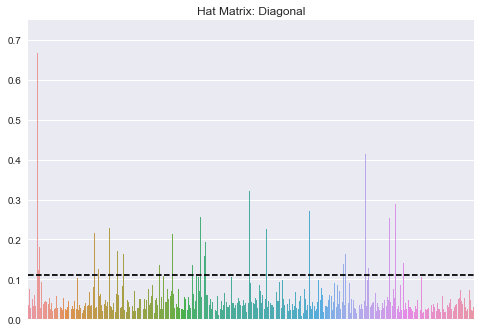

In [51]:
n = X.shape[0]
p = X.shape[1]
threshold = ((2.0*p)/n)
Hdiag = np.diag(H)
sns.barplot(range(len(Hdiag)), Hdiag)
gca().plot(range(len(Hdiag)), threshold*np.ones(len(Hdiag)), 'k--')
gca().set_xticklabels('')
gca().set_title("Hat Matrix: Diagonal")
plt.show()

The chart above shows values of the diagonal elements of the hat matrix, together with the threshold for a point to be considered significant,

$$
h_{ii} > \dfrac{2p}{n}
$$

where $n$ is the number of observations and $p$ is the number of explanatory variables. 

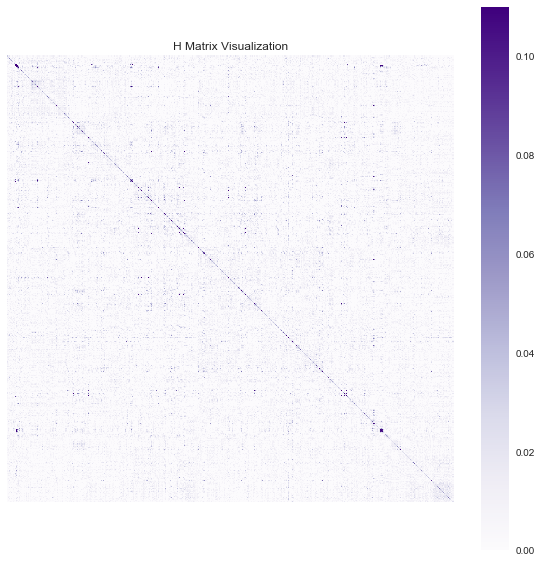

In [52]:
#print H
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

sns.heatmap(H[:,:], 
            annot=False, square=True,
            vmin=0.0,vmax=threshold, cmap=plt.cm.Purples,
            ax=ax)
ax.set_xticklabels('')
ax.set_yticklabels('')
plt.title("H Matrix Visualization")
plt.show()

The dark spots on the diagonal of the H matrix above indicate that that observation has a strong effect on its own prediction. 

The diagonal elements satisfy the identity,

$$
h_{ii} = \dfrac{ \partial \hat{y}_i }{\partial y_i}
$$

while the off-diagonal elements $h_{ij}$ indicate the effect exerted by the $j^{th}$ observation (column $j$) on the $i^{th}$ response variable prediction $\hat{y}_{i}$.

### Eliminating Highly Influential Points

Ideally we want to eliminate points that have very large $h_{ii}$ values, as they represent outliers, or points whose influence is outsized. This makes the entire model prone to contamination by a few points.

These highly influential points would need to be removed before performing any kind of linear regression. However, we are not performing regression here (no inputs or outputs, looking at all process variables together).

Create a function to plot time series with the large $h_{ii}$ outliers marked:

In [59]:
print df_io.shape
print H.shape


(527, 30)
(527, 527)


In [79]:
def make_hatmatrix_outlier_timeseries(df, lab1, lab2, normal_cutoff, mycolor1, myoutliercolor1, mycolor2, myoutliercolor2):
    df.loc[:,'h_ii'] = np.diag(H)
    
    
    fig = plt.figure(figsize=(8,8))
    ax1, ax2 = [fig.add_subplot(211+k) for k in range(2)]

    
    normal_x = df['Date'][df['h_ii']<normal_cutoff]
    normal_y = df[lab1][df['h_ii']<normal_cutoff]
    irregular_x = df['Date'][df['h_ii']>normal_cutoff]
    irregular_y = df[lab1][df['h_ii']>normal_cutoff]
    
    ax1.plot(normal_x, normal_y, 'o', color=mycolor1)
    ax1.plot(irregular_x, irregular_y, 'o', color=myoutliercolor1, label="Outliers")
    
    ax1.set_title("Time Series: "+lab1+"\nOutliers Identified with Hat Matrix",size=14)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(lab1+" Value")
    ax1.legend()

    
    
    
    normal_x = df['Date'][df['h_ii']<normal_cutoff]
    normal_y = df[lab2][df['h_ii']<normal_cutoff]
    irregular_x = df['Date'][df['h_ii']>normal_cutoff]
    irregular_y = df[lab2][df['h_ii']>normal_cutoff]
    
    ax2.plot(normal_x, normal_y, 'o', color=mycolor2)
    ax2.plot(irregular_x, irregular_y, 'o', color=myoutliercolor2, label="Outliers")
    
    ax2.set_title("Time Series: "+lab2+"\nOutliers Identified with Hat Matrix",size=14)
    ax2.set_xlabel("Date")
    ax2.set_ylabel(lab2+" Value")
    ax2.legend()

    
    fig.subplots_adjust(hspace = 0.5)

    plt.show()

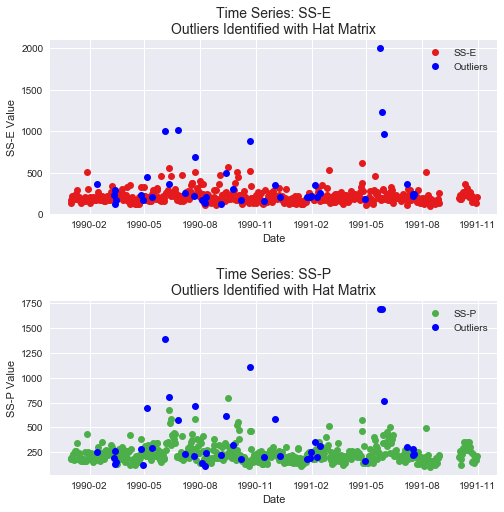

In [85]:
make_hatmatrix_outlier_timeseries(df_io, 'SS-E', 'SS-P', threshold, colorz[0], 'b', colorz[1], 'b')

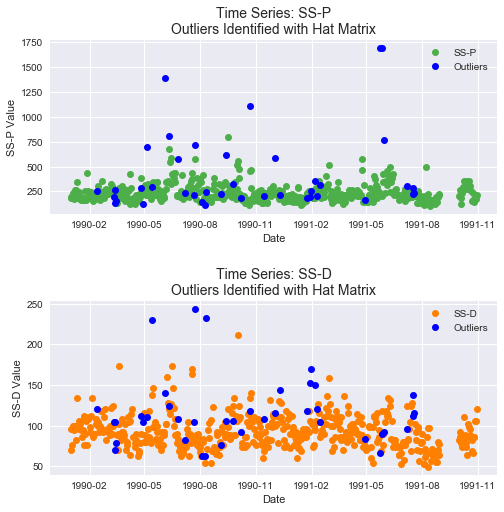

In [86]:
make_hatmatrix_outlier_timeseries(df_io, 'SS-P', 'SS-D', threshold, colorz[1], 'b', colorz[2], 'b')

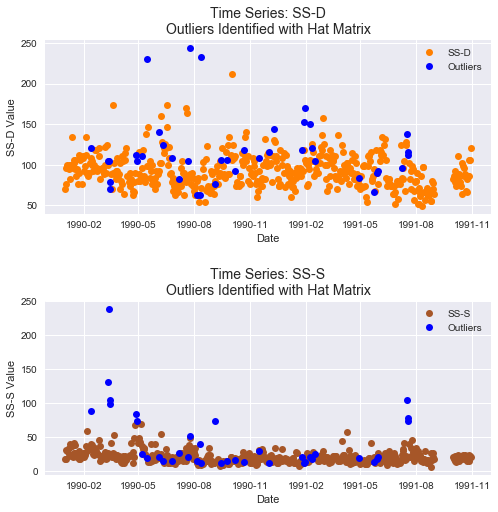

In [87]:
make_hatmatrix_outlier_timeseries(df_io, 'SS-D', 'SS-S', threshold, colorz[2], 'b', colorz[3], 'b')

### Mahalanobis Distance

Note that we are not performing regression with a constant in this case, but if we were then the Mahalanobis distance is another measure that is useful in quantifying the distance between an observation and the bulk of the observations, providing another measure for outliers.

We can also use the $H$ matrix to compute the Mahalanobis distance. The diagonals of the hat matrix are related to the Mahalanobis distance as follows:

$$
MD_i^2 = (n-1) \left( h_{ii} - \frac{1}{n} \right)
$$

In [54]:
MDs = []
n = X.shape[0]
p = X.shape[1]
for h_ii in Hdiag:
    md = (n-1.0)*(h_ii - (1.0/n))
    MDs.append( md )

Note that we're using all of the observations that occur before and after each stage - 29 observations in total. That means we're looking through 29-dimensional space and trying to find outliers...

Those 29 dimensions are out of the 38 total inputs:

In [55]:
print X.shape
print info.shape

(527, 29)
(38, 2)


### Jackknifed Residuals

The jackknifed residual, also called the studentized residual or the cross validatory residual, accounts for the influence of each point on its own prediction, and adjusts the value of a residual from a least squares model according to:

$$
t(i) = \dfrac{r_i}{s(i) \sqrt{1-h_{ii}}}
$$

where $s(i)$ is the estimate of $\sigma$ when regression is run without the observation $i$.

$r_i$ is the residual $t(i)$ is the studentized residual.



In [18]:
n_samples = df.shape[0]
outliers_fraction = 0.25


classifiers = {
    "One-Class SVM"    : svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    
    "Isolation Forest" : IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction)}

Fitting Isolation Forest...


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/iforest.py:184: UserWarning: max_samples (527) is greater than the total number of samples (526). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Done.
Getting predictions...
Done.
Getting decision function...
Done.


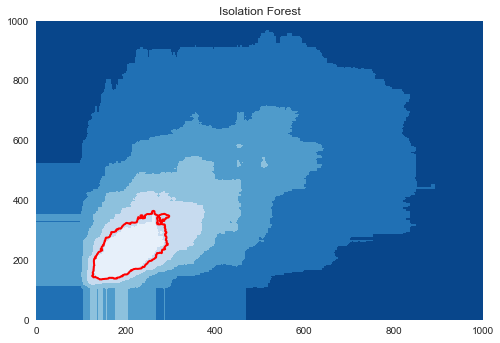

Fitting One-Class SVM...
Done.
Getting predictions...
Done.
Getting decision function...
Done.


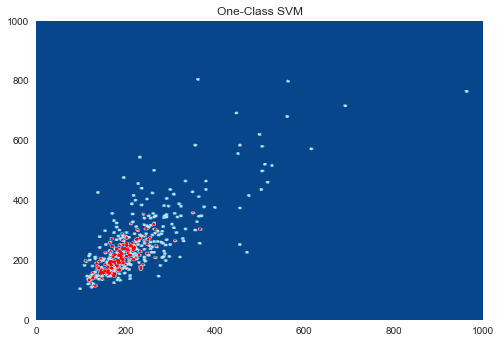

Fitting Robust covariance...
Done.
Getting predictions...
Done.
Getting decision function...
Done.


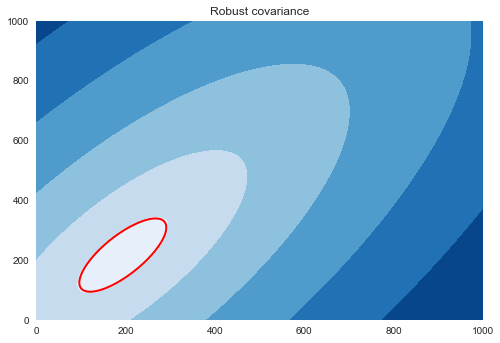

In [19]:
def plot_svm(lab1, lab2, clfkey, clf, mycolor):
    
    xx, yy = np.meshgrid(np.linspace(0,1000, 500), np.linspace(0,1000, 500))
    
    dat = df[[lab1, lab2]].dropna()
    X = dat.values
    
    print "Fitting "+clfkey+"..."
    clf.fit(X)
    print "Done."
    
    scores_pred = clf.decision_function(X)
    
    print "Getting predictions..."
    y_pred = clf.predict(X)
    print "Done."

    print "Getting decision function..."
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    print "Done."
    
    threshold = stats.scoreatpercentile(scores_pred, 25)
    plt.contour(xx, yy, Z, levels=[threshold],
                linewidths=2, colors='red')
    
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.Blues_r)
    plt.xlim([0,1000])
    plt.ylim([0,1000])
    plt.title(clfkey)
    
    plt.show()

for i, (clfkey, clf) in enumerate(classifiers.items()):
    plot_svm('SS-E','SS-P',clfkey,clf,colorz[0])

In [20]:


    # Fit the model
    plt.figure(figsize=(10.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()

IndentationError: unexpected indent (<ipython-input-20-63062f4dd016>, line 4)